<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson6_DeepPot-FNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: DeepPot-Smooth Edition Fitting Neural Network with Machine Learning Potentials (DeepPot-SE-FNN MLP)

$\Delta$ MLP  with PyTorch for the Claisen Rearrangement reaction

For this tutorial, we will be combining the Fitting Neural Network (FNN) from Lesson 1 and the DeepPot-Smooth Edition (DeepPot-SE) from Lesson 4 to train a $\Delta$ Machine Learning Potential ($\Delta$MLP) model to reproduce the energy and forces for the Claisen Rearrangement reaction. With a DeepPot-SE-FNN, we can utilize the properties from the local environment defined in the DeepPot-SE model for feature extraction and use the FNN for training. The goal of this model is to train with data calculated using semiempirical (PM3) and DFT (B3LYP) levels of theory. The DeepPot-SE-FNN will be used to correct the semiempirical values to obtain DFT level accuracy, that makes it a $\Delta$MLP model.
The reaction coordinate is constructed by stretching the $d_2$ bond distance, while shrinking the $d_1$ bond distance. The reaction is sampled with 21 windows along the $d_1-d_2$ reaction coordinate

Total of 2100 frames (1 ps/window) are saved every 1 fs.

<img src='https://raw.githubusercontent.com/cc-ats/mlp_class/main/Claisen_Rearrangement/img/pent-4-enal.png' width=200px>


In [ ]:
from IPython.display import HTML

HTML(f"""<video src="https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/img/claisen.mp4" width=300 controls/>""")

## Importing PyTorch Lightning and  Libraries
We will first install PyTorch Lightning and import libraries needed to train our machine learning models.


In [ ]:
%%capture
!pip install pytorch-lightning > /dev/null

import math
import numpy as np
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

## Defining the Dense Neural Network

The Dense class contains functions to describe a densely connected neural network.

In [ ]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input

class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)

        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )

## DeepPot-SE Local Environment

Given the atomic coordinates $R$, we can build an environment matrix that describes the local envrionment for each atom $i$ in the molecule. We can then turn the environment matrix into the feature matrix $D_i$ and then map each of the feature matrices into the local energy. This will be done in a manner that preserves translational, rotational, and permutational symmetry. We can obtain our total energy by then summing the local energy values together, which ensures that our total energy is extensive. A schematic of this is shown below:

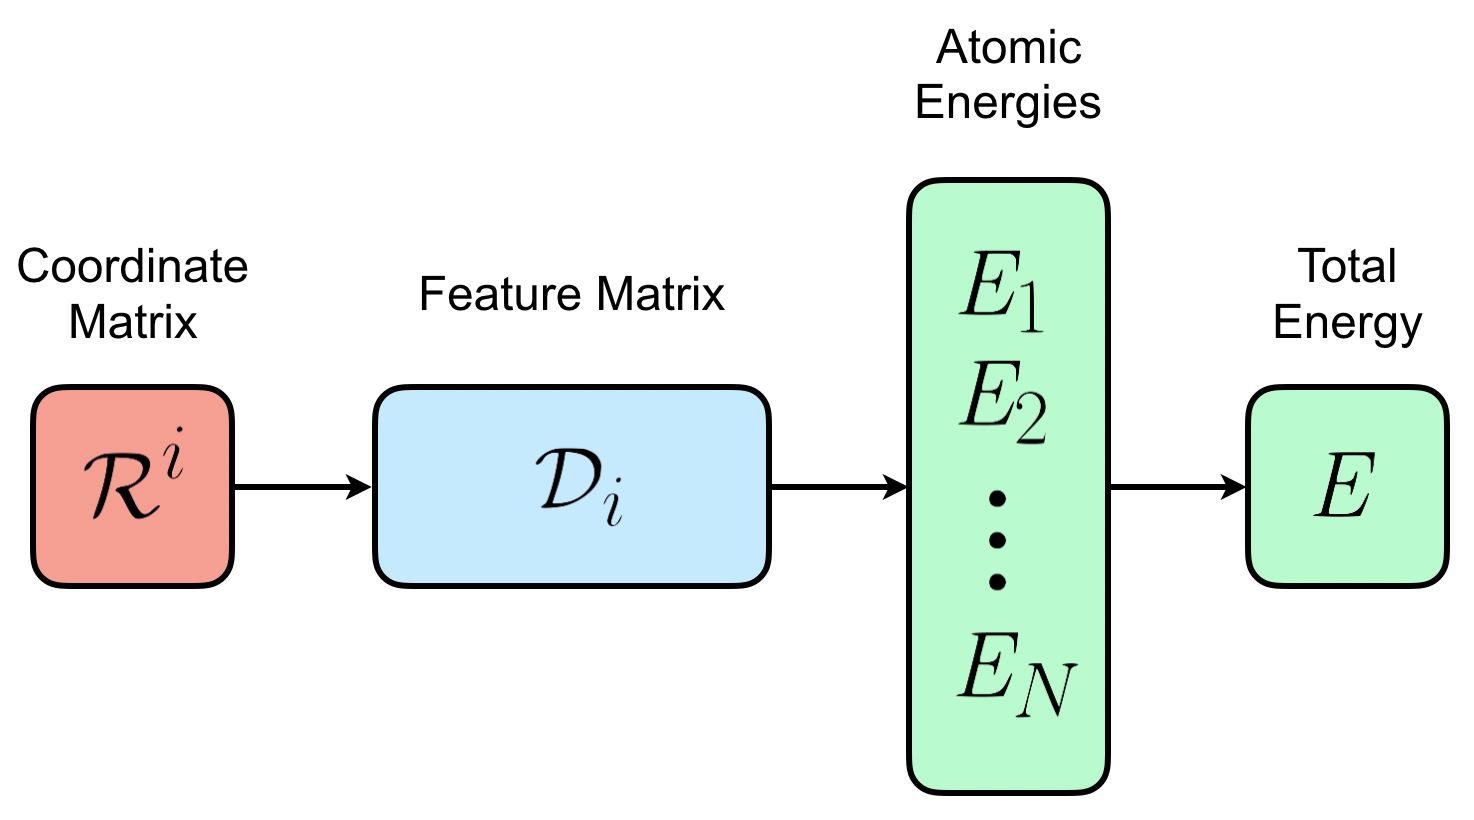

First, we build the environment matrix for each atom ${\tilde{\mathcal{R}}^i}$

$$\begin{eqnarray}
{\tilde{\mathcal{R}}^i}  = \begin{pmatrix}
s(R_{1i}) & s(R_{1i}) \frac{x_{1i}}{R_{1i}} & s(R_{1i}) \frac{y_{1i}}{R_{1i}} & s(R_{1i}) \frac{z_{1i}}{R_{1i}} \\ \\
s(R_{2i}) & s(R_{2i}) \frac{x_{2i}}{R_{2i}} & s(R_{2i}) \frac{y_{i1}}{R_{2i}} & s(R_{2i}) \frac{z_{2i}}{R_{2i}}  \\ \\
\cdots & \cdots & \cdots & \cdots  \\ \\
s(R_{n_ii}) & s(R_{n_ii}) \frac{x_{n_ii}}{R_{n_ii}} & s(R_{n_ii}) \frac{y_{n_ii}}{R_{n_ii}} & s(R_{n_ii}) \frac{z_{n_ii}}{R_{n_ii}}
\end{pmatrix}
\end{eqnarray}$$
<br/>

where $n_i$ is the number of neighbors for atom $i$ and $s$ is the weighting function.

$$\begin{eqnarray}
s(R_{ji}) =
\begin{cases}
    \frac{1}{R_{ji}}, & R_{ji} < R_{cs}\\
    \frac{1}{R_{ji}} \left( \frac{1}{2} \cos{\left[ \pi \frac{(R_{ji} - R_{cs})}{(R_{c} - R_{cs})}\right] + \frac{1}{2}} \right), & R_{cs} < R_{ji} < R_{c}\\
    0,               & R_{ji} > R_c.
\end{cases}
\end{eqnarray}$$

The weighting function in the DeepPot-SE scales down the interaction between the atoms $i$ and $j$ as the distance becomes greater than $R_{cs}$ and approaches 0 near the cutoff distance $R_c$. It sets the interaction to 0 for atoms that are beyond the $R_c$ distance. This ensures that $s$ is continuous and differentiable.

We define the $\,\it{local\_environment}\,$ function below and remove self-interactions.

In [ ]:
def local_environment(coords: Tensor) -> Tuple[Tensor, Tensor]:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    dij = torch.norm(rij, dim=3)
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    dij = torch.masked_select(dij, mask).view(num_batches, num_channels, num_channels - 1)
    dij_inv = 1 / dij
    dij2_inv = dij_inv * dij_inv

    loc_env_r = dij_inv
    loc_env_a = rij * dij2_inv.unsqueeze(3)

    return loc_env_r, loc_env_a

## DeepPot-SE Local Embedding Matrix and Embedded Feature Matrix

After generating the environment matrix, we now need to generate atomic energy components while preserving translational, rotational, and permutational symmetry. The entire DeepPot scheme is presented below:

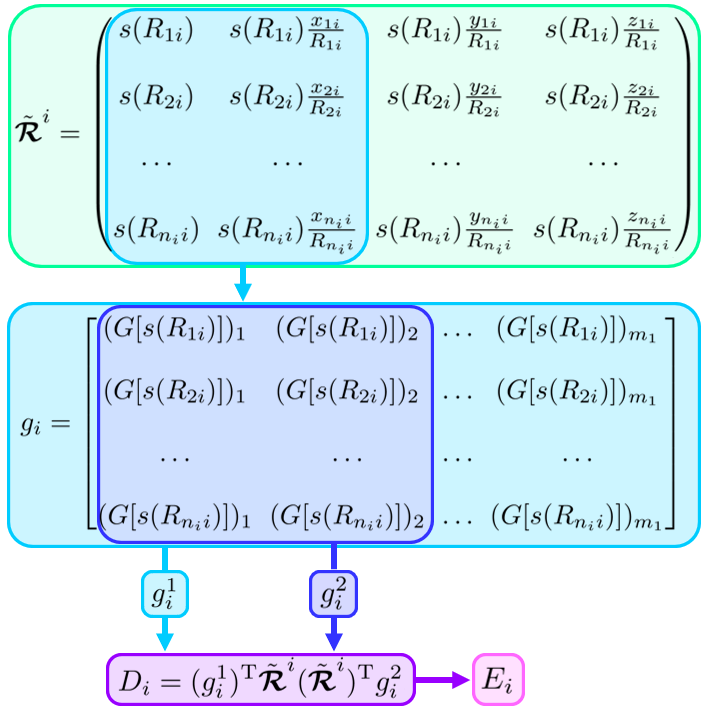

Now we use embedding neural networks to transform each of the $s$ values into $m_1$ numbers. This gives us the local embedding matrix $g_i$. Note the embedding neural network parameters depend on the chemical species of atom $i$ and atom $j$.  

$$\begin{eqnarray}
g_i
= \begin{pmatrix}
\left( G[s(R_{1i})] \right)_1  &
\left( G[s(R_{1i})] \right)_2  &  \cdots  &
\left( G[s(R_{1i})] \right)_{m_1}  \\
\left( G[s(R_{2i})] \right)_1  &
\left( G[s(R_{2i})] \right)_2  &  \cdots  & \left( G[s(R_{2i})] \right)_{m_1}  \\
\cdots & \cdots & \cdots & \cdots \\
\left( G[s(R_{n_ii})] \right)_1  &
\left( G[s(R_{n_ii})] \right)_2  &  \cdots  & \left( G [s(R_{n_ii})] \right)_{m_1}
\end{pmatrix}
\end{eqnarray}$$

Two local embedding matrices are used: $g_{i}^{1}$ is $n\times m_1$ dimensions, while $g_{i}^{2}$ is $n\times m_2$ dimensions. The dimensions $m_1$ and $m_2$ represent the number of neural network parameters, where $m_1$ is larger than $m_2$.

By multiplying our local embedding matrices and environment matrices, we can preserve the translational, rotational, and permutational symmetry in the form of the encoded feature matrix $D_i$  

$$\begin{eqnarray}
D_i = \left( g_i^1   \right)^T \tilde{\mathcal{R}}^i  (\tilde{\mathcal{R}}^i)^T g_i^2
\end{eqnarray}$$

The local feature matrix is then mapped to the atomic energy using the fitting neural network. Finally, the atomic energies are summed to yield the total energy of the molecule.

## Defining Classes for the Neural Network


### The Feature Class

Here we define the feature class, which uses the local environment matrix ($\tilde{\mathcal{R}}^i$) and local embedding matrices ($g_{i}^{1}$ and $g_{i}^{2}$) to construct the encoded feature matrix ($D_i$).

In [ ]:
class Feature(nn.Module):
    def __init__(self, n_types: int, neuron: Sequence[int] = [25, 50, 100], axis_neuron: int = 4) -> None:
        super().__init__()
        self.n_types = n_types
        self.neuron = neuron
        self.axis_neuron = axis_neuron

        layers = [Dense(n_types * n_types, 1, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types * n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        self.local_embedding = Sequential(*layers)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        loc_env_r, loc_env_a = local_environment(coords)

        neighbor_types = atom_types.repeat(num_channels, 1)
        mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device)
        neighbor_types = torch.masked_select(neighbor_types, mask).view(num_channels, -1)
        indices = ((atom_types * self.n_types).unsqueeze(-1) + neighbor_types).view(-1)

        output, _ = self.local_embedding((loc_env_r.view(num_batches, -1, 1), indices))
        output = output.view(num_batches, num_channels, num_channels - 1, -1)

        output = torch.transpose(output, 2, 3) @ (loc_env_a @ (torch.transpose(loc_env_a, 2, 3) @ output[..., :self.axis_neuron]))
        output = output.view(num_batches, num_channels, -1)

        return output

    @property
    def output_length(self) -> int:
        return self.neuron[-1] * self.axis_neuron

### The Fitting Class

Now we define the fitting neural network that maps the encoded feature matrix into the atomic energy values.

In [ ]:
class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

### The DeepPot Class

We define the DeepPot class to extract features from a data set using local environment properties for training a neural network model.

In [ ]:
class DeepPot(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 10,
                    }
        return [optimizer], [scheduler]

## Importing Data and Feature Extraction

We will now import our semiempirical and DFT calculation data, which will be used by the DeepPot model for feature extraction. We will then use seeding to generate random but reproducible training.


In [ ]:
%%capture
import numpy as np

ds = np.DataSource(None)
qm_coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_elem.txt", "r"), dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(qm_coord), axis=0)

energy = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy", "rb"))) * 27.2114 * 23.061, dtype="float32")
energy = energy - energy.mean()
qm_gradient = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy", "rb"))) * 27.2114 * 23.061 / 0.529177249, dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qm_coord = torch.from_numpy(qm_coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
energy = torch.from_numpy(energy).to(device)
qm_gradient = torch.from_numpy(qm_gradient).to(device)

In [ ]:
pl.seed_everything(2)
dataset = TensorDataset(qm_coord, atom_types, energy, qm_gradient)
train, val = random_split(dataset, [2016, 84])
# Training Set Size: 2016 (96%)
# Test Set Size:       84 ( 4%)
# Data Set Size:     2100
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

INFO:lightning_fabric.utilities.seed:Global seed set to 2


### Training the Neural Network

Now we begin training our NN using the training and validation datasets.


In [ ]:
%%capture
%%time
pl.seed_everything(2)
descriptor = Feature(3, neuron=[25, 50, 100], axis_neuron=4)
fitting_net = Fitting(3, descriptor.output_length)
model = DeepPot(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=300, logger=csv_logger, log_every_n_steps=20, accelerator='auto')
trainer.fit(model, train_loader, val_loader)
model.to(device)

INFO:lightning_fabric.utilities.seed:Global seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type    | Params
----------------------------------------
0 | descriptor  | Feature | 58.1 K
1 | fitting_net | Fitting | 636 K 
----------------------------------------
694 K     Trainable params
0         Non-trainable params
694 K     Total params
2.778     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


### Saving the Model to a PyTorch File

The following files are saved:

**1) model.pt**
- torch.save saves tensors to model.pt

**2) model_script.pt**
- torch.jit.save attempts to preserve the behavior of some operators across PyTorch versions.


Previously saved models can be loaded with:
 - model.load_state_dict(torch.load("model.pt"))
 - torch.jit.load("model_script.pt")

In [ ]:
torch.save(model.state_dict(), 'model.pt')
torch.jit.save(model.to_torchscript(), "model_script.pt")

In [ ]:
ene_pred, grad_pred = model(qm_coord, atom_types[0])

## Plotting RMSD for the $\Delta$MLP and Training Errors

### Plotting RMSD for $\Delta$MLP Energy and Forces
RMSD for predicted and reference energy and forces are calculated and displayed below.

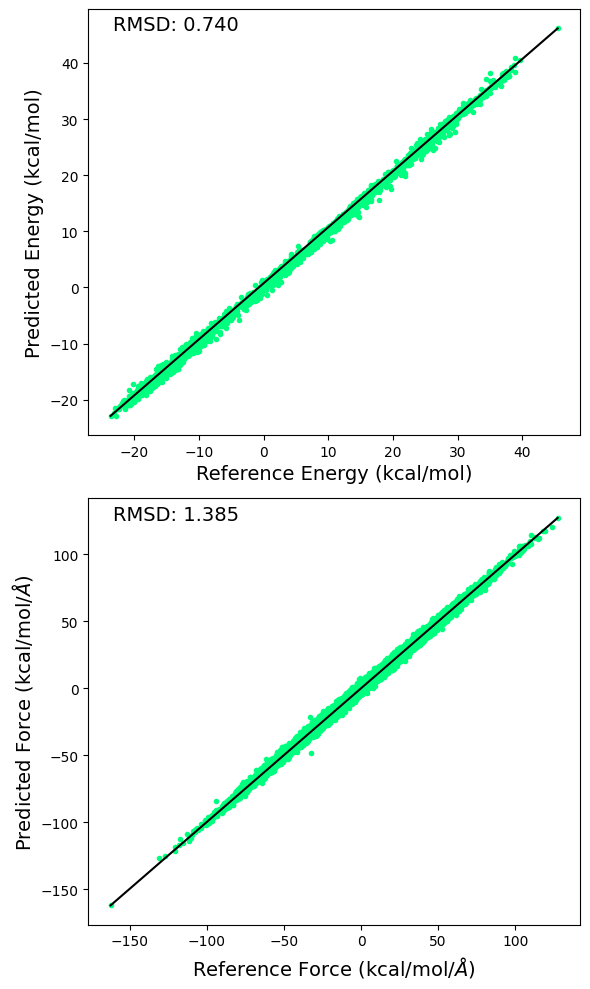

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,figsize=(6,10))

e1 = energy.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
e2 = ene_pred.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', color='springgreen')
ax[0].plot([np.max(e1), np.min(e1)], [np.max(e2), np.min(e2)] , color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_pred.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', color='springgreen')
ax[1].plot([np.max(f1), np.min(f1)], [np.max(f2), np.min(f2)] , color="k", linewidth=1.5)
ax[1].set_xlabel(r'Reference Force (kcal/mol/$\AA$)', size=14)
ax[1].set_ylabel(r'Predicted Force (kcal/mol/$\AA$)', size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

### The Model Weights and Biases Dictionary

This cell prints the size of the weights and biases used in the trained model for reference.

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
descriptor.local_embedding.0.weight 	 torch.Size([9, 25, 1])
descriptor.local_embedding.0.bias 	 torch.Size([9, 25])
descriptor.local_embedding.1.weight 	 torch.Size([9, 50, 25])
descriptor.local_embedding.1.bias 	 torch.Size([9, 50])
descriptor.local_embedding.2.weight 	 torch.Size([9, 100, 50])
descriptor.local_embedding.2.bias 	 torch.Size([9, 100])
fitting_net.fitting_net.0.weight 	 torch.Size([3, 240, 400])
fitting_net.fitting_net.0.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.1.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.1.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.2.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.2.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.3.weight 	 torch.Size([3, 1, 240])
fitting_net.fitting_net.3.bias 	 torch.Size([3, 1])


### Plotting Training and Validation Loss for $\Delta$MLP

The loss at each step of the training process is displayed below.

945
300


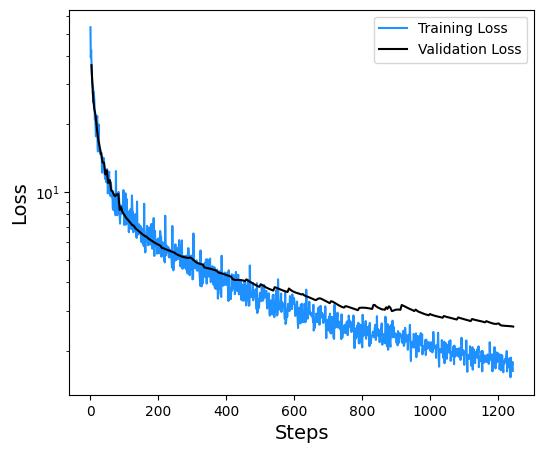

In [ ]:
import pandas as pd

data = pd.read_csv(f'logs_csv/lightning_logs/version_{csv_logger.version}/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Training Loss',color='dodgerblue')
y = data['val_loss'][~data['val_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Validation Loss',color='k')
plt.xlabel('Steps',size=14)
plt.ylabel('Loss',size=14)
plt.legend()
plt.savefig('loss.png', dpi=300)